In [1]:
from ngsolve import *
import netgen.gui
from netgen.geom2d import *

import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp

In [2]:
geo = SplineGeometry()
a = 3
cringx = a/2
cringy = a/3
rring = 0.8
geo.AddRectangle((0,0), (a,a), bc = "air", leftdomain=1, rightdomain=0)
z = 2
#geo.AddRectangle((0,0), (a,a), bc=['bottom','right','top','left'], leftdomain=1, rightdomain=0)
p1,p2,p3,p4 = [ geo.AppendPoint(x,y) for x,y in [(z,z), (1/2+z,z), (1/2+z,1+z), (z,1+z)] ]

geo.AddCircle(c=(cringx,cringy), r=rring, bc = "glas", leftdomain=2, rightdomain=1)
geo.AddCircle(c=(cringx,cringy), r=rring-0.1,bc = "glas", leftdomain=1, rightdomain=2)

geo.SetMaterial (1, "air")
geo.SetMaterial (2, "glas")

#geo.Append (["spline3", p2, p3, p4])
#geo.Append (["line", p4, p1])

mesh = Mesh(geo.GenerateMesh(maxh=0.1))
Draw(mesh)

In [3]:
maxind = 20
fes = H1(mesh, order=5,complex = True)
#fes = H1(mesh, order=5,dirichlet=".*")
gfu = GridFunction(fes,name = "u")
erg = np.zeros([len(gfu.vec),maxind],dtype = complex)
fh = np.zeros(len(gfu.vec),dtype = complex)

piha = 1

source = exp(-50**2*((x-a/2)*(x-a/2)+(y-1.5)*(y-1.5)))
Draw(source,mesh,name = "pulse")

In [12]:
u = fes.TrialFunction()
v = fes.TestFunction()

A = BilinearForm(fes)
K = BilinearForm(fes)
M = BilinearForm(fes)
F = LinearForm(fes)
R = BilinearForm(fes)

omega = Parameter(1)
A += (grad(u)*grad(v)- omega**2*u*v)*dx
K += grad(u)*grad(v)*dx
M += u*v*dx
R += -1j*u*v*ds(definedon=mesh.Materials('glas'))
A += -1j*omega*u*v*ds(definedon=mesh.Materials('glas'))


#A += 1j*omega*u*v*ds # R 
F += source*v*dx  
o = []  

norm = []

#o = verg[0:21]
for i in range(0,maxind):
    o.append(i)

j = 0
Draw(gfu)
for i in o:   
    omega.Set(i) 
    A.Assemble()
    K.Assemble()
    M.Assemble()
    F.Assemble()  
    R.Assemble() 
    gfu.vec.data = A.mat.Inverse(fes.FreeDofs()) * F.vec
    erg[:,j] = gfu.vec
    fh = F.vec
    norm.append(sqrt (Integrate ((gfu)*(gfu),mesh)))
    print("Number of iter: ",j,"omega: ",i,"L2-Norm:",sqrt (Integrate ((gfu)*(gfu),mesh)))
    j = j+1
#As = A.mat
Ms = M.mat
Ks = K.mat
Rs = R.mat
rows,cols,vals = Ms.COO()
Mh = sp.csr_matrix((vals,(rows,cols)))
rows,cols,vals = Ks.COO()
Kh = sp.csr_matrix((vals,(rows,cols)))
rows,cols,vals = Rs.COO()
Rh = sp.csr_matrix((vals,(rows,cols)))
#rows,cols,vals = As.COO()
#Ah = sp.csr_matrix((vals,(rows,cols)))
#Ah = sp.csr_matrix.toarray(Ah)

Number of iter:  0 omega:  0 L2-Norm: (1103193997143.4453+0j)
Number of iter:  1 omega:  1 L2-Norm: (0.0006776856641524565-4.018104906098464e-05j)
Number of iter:  2 omega:  2 L2-Norm: (0.0009226819909839049+0.00017046151861706385j)
Number of iter:  3 omega:  3 L2-Norm: (0.00019763492103189731-1.8897303169683981e-06j)
Number of iter:  4 omega:  4 L2-Norm: (0.0004212301664882972+8.491877239523737e-05j)
Number of iter:  5 omega:  5 L2-Norm: (0.00043840686151651515-0.00036791200642074574j)
Number of iter:  6 omega:  6 L2-Norm: (0.00021290915847537375+9.291640649724686e-05j)
Number of iter:  7 omega:  7 L2-Norm: (0.00030728389600789477-6.749373006501178e-07j)
Number of iter:  8 omega:  8 L2-Norm: (0.00024360663860066963-7.716440587467135e-05j)
Number of iter:  9 omega:  9 L2-Norm: (0.00025841865902998277+2.8817740892062923e-05j)
Number of iter:  10 omega:  10 L2-Norm: (0.00022899478987121235+7.643201332251017e-05j)
Number of iter:  11 omega:  11 L2-Norm: (0.00032955824039872255+5.411005903

Text(0, 0.5, 'Euklidic-Norm')

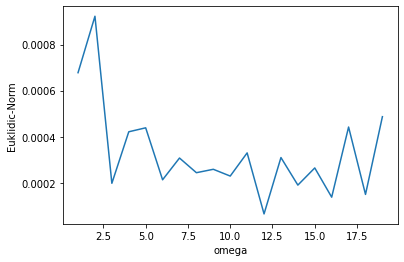

In [13]:
plt.plot(o[1:20],norm[1:20])
plt.xlabel("omega")
plt.ylabel("Euklidic-Norm")
#plt.savefig('results/resonanz_20.png')

In [14]:
V, r = np.linalg.qr(erg)
V = erg.dot(np.linalg.inv(r))
print(np.vdot(V[:,1],(V[:,2])))
len(V)

(5.074066167232161e-16+6.245004513516506e-17j)


24376

In [15]:
MN = np.transpose(V).dot(Mh.dot(V))
KN = np.transpose(V).dot(Kh.dot(V))
fN = np.transpose(V).dot(fh)
RN = np.transpose(V).dot(Rh.dot(V))

In [ ]:
iteration = int(100)
interval = 20
factor = interval / iteration
omegaN = []
norm_L2 =[]
uN = np.zeros([maxind,iteration])
for i in range(iteration):
    omegaN.append(factor*i)
    uN[:,i] = np.linalg.solve(KN-omegaN[i]**2*MN+omegaN[i]*RN, fN)
    new = uN[:,i].dot(np.transpose(V))
    gif = GridFunction(fes,name = "gif")
    gif.vec.FV().NumPy()[:] = new
    Draw(gif)
    print("i: ",i,"Omega: ",omegaN[i])
    input()
    Redraw()
    #norm_L2.append(sqrt(uN[:,i].dot(uN[:,i])))

In [ ]:



iteration = int(1e3)
interval = 20
factor = interval / iteration
omegaN = []
norm_L2 =[]
res = []
uN = np.zeros([maxind,iteration])
for i in range(iteration):
    print(i)
    omegaN.append(factor*i)
    uN[:,i] = np.linalg.solve(KN-omegaN[i]**2*MN, fN)
    res.append(np.linalg.norm((Kh-omegaN[i]**2*Mh).dot(uN[:,i].dot(np.transpose(V)))-fN.dot(np.transpose(V))))
    norm_L2.append(sqrt(uN[:,i].dot(uN[:,i])))

In [ ]:


#plt.semilogy(verg[0:maxpoints],point[0:maxpoints],'*r')
plt.semilogy(omegaN[10:],norm_L2[10:],'b')
plt.xlabel("omega")
plt.ylabel("Euclidic Norm")
#plt.savefig('results/resonanz_RB_20.png')

In [ ]:
plt.semilogy(omegaN,res)
plt.xlabel("omega")
plt.ylabel("Euclidic Norm")